See the first version of this notebook [here](https://github.com/rajewsky-lab/planarian_lineages/blob/1741fc376574393980b7976b764ccdd536615150/graph_abstraction/planaria.ipynb).

# Planarian lineages: cell map from PAGA

This notebook reproduces the main cell map with its lineage relations. For this, it uses the [Scanpy](https://github.com/theislab/scanpy) package.

All necessary files can be downloaded from the download section on https://shiny.mdc-berlin.de/psca/.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/planaria.h5ad'

scanpy==1.0.3+0.g33bccc7.dirty anndata==0.5.8+3.gf10296c numpy==1.14.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


Some plotting parameters.

In [2]:
paga_plot_params = dict(
    legend_fontsize=5,
    root='neoblast 1',
    layout='rt_circular',
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=3.5)

## Reading

We use Seurat's preprocessing and its resulting PCA representation of the data.

In [4]:
adata = sc.read('./data/R_pca_seurat.txt')
clusters = pd.read_csv('./data/R_annotation.txt', header=None)
adata.obs['clusters'] = clusters[0].values
adata.uns['iroot'] = 6  # root cell (the first neoblast in the file)

In [5]:
adata

AnnData object with n_obs × n_vars = 21612 × 50 
    obs: 'clusters'
    uns: 'iroot'

## Embeddings

Compute the tSNE.

In [6]:
sc.tl.tsne(adata)

computing tSNE
    using data matrix X directly
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:01:23.03)


Add some colors.

In [7]:
sc.utils.sanitize_anndata(adata)
colors = pd.read_csv('./data/colors_dataset.txt', header=None, sep='\t')
colors = {k: c for k, c in colors.values}
adata.uns['clusters_colors'] = [colors[clus] for clus in adata.obs['clusters'].cat.categories]

... storing 'clusters' as categorical


Do the actual plotting.

saving figure to file ./figures/tsne_full.png


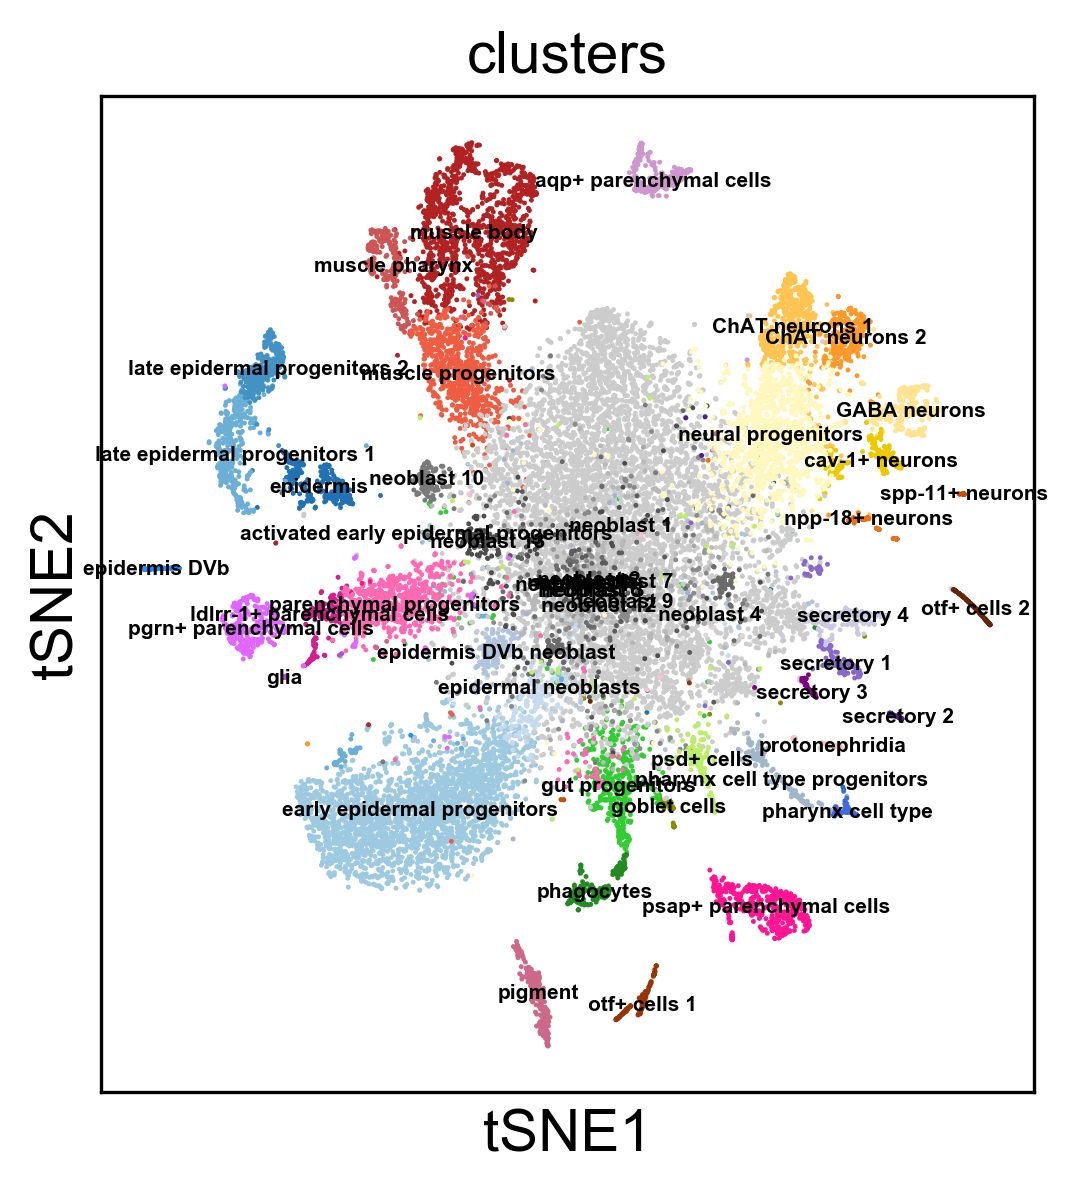

In [4]:
sc.pl.tsne(adata, color='clusters', legend_loc='on data', legend_fontsize=5, save='_full')

Let's save this.

In [5]:
adata.write(results_file)

**Note:** This is the only step that takes a long time to compute, you can safely skip this.

In [9]:
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.draw_graph(adata)
adata.write(results_file)

drawing single-cell graph using layout "fr"
    finished (0:51:25.332)


saving figure to file ./figures/draw_graph_fr_full.png


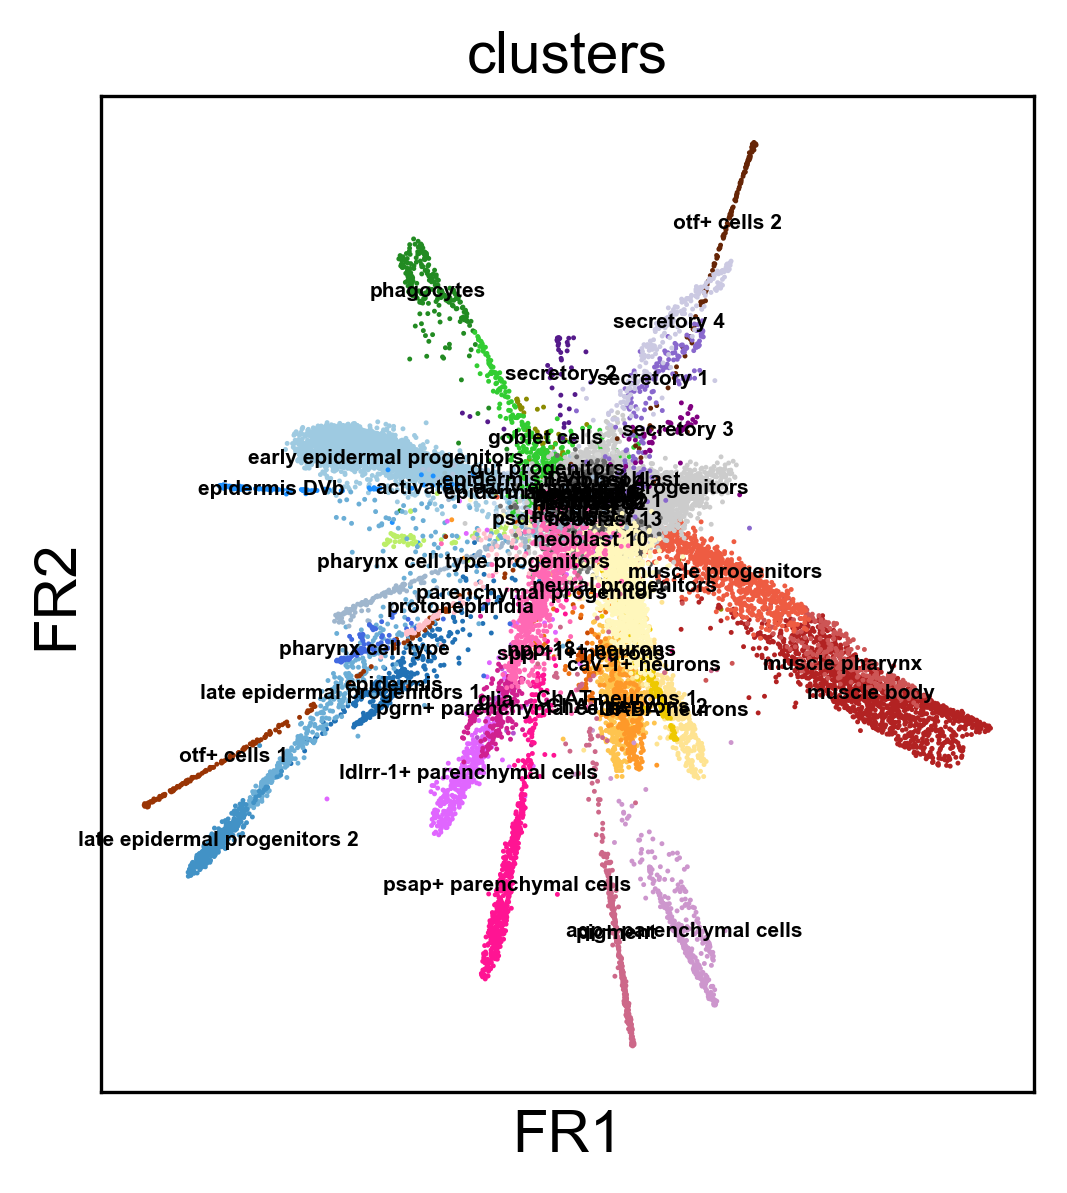

In [9]:
adata = sc.read(results_file)
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data', legend_fontsize=5, save='_full')

## Cell map from PAGA

In [9]:
adata = sc.read(results_file)
sc.pp.neighbors(adata, n_neighbors=30)  # only need this if we didn't call it above already
sc.tl.paga(adata, groups='clusters')
adata.write(results_file)

computing neighbors
    using data matrix X directly
    finished (0:00:19.99)
running partition-based graph abstraction (PAGA)
    initialized `.distances` `.connectivities` 
    finished (0:00:02.21)


Even though the layout of the tree differs slightly from the one in the supplement, the tree itself is exactly the same [the changed layout is just a consequence of the changed order of categories in the final files].

saving figure to file ./figures/paga_compare_100percent.png


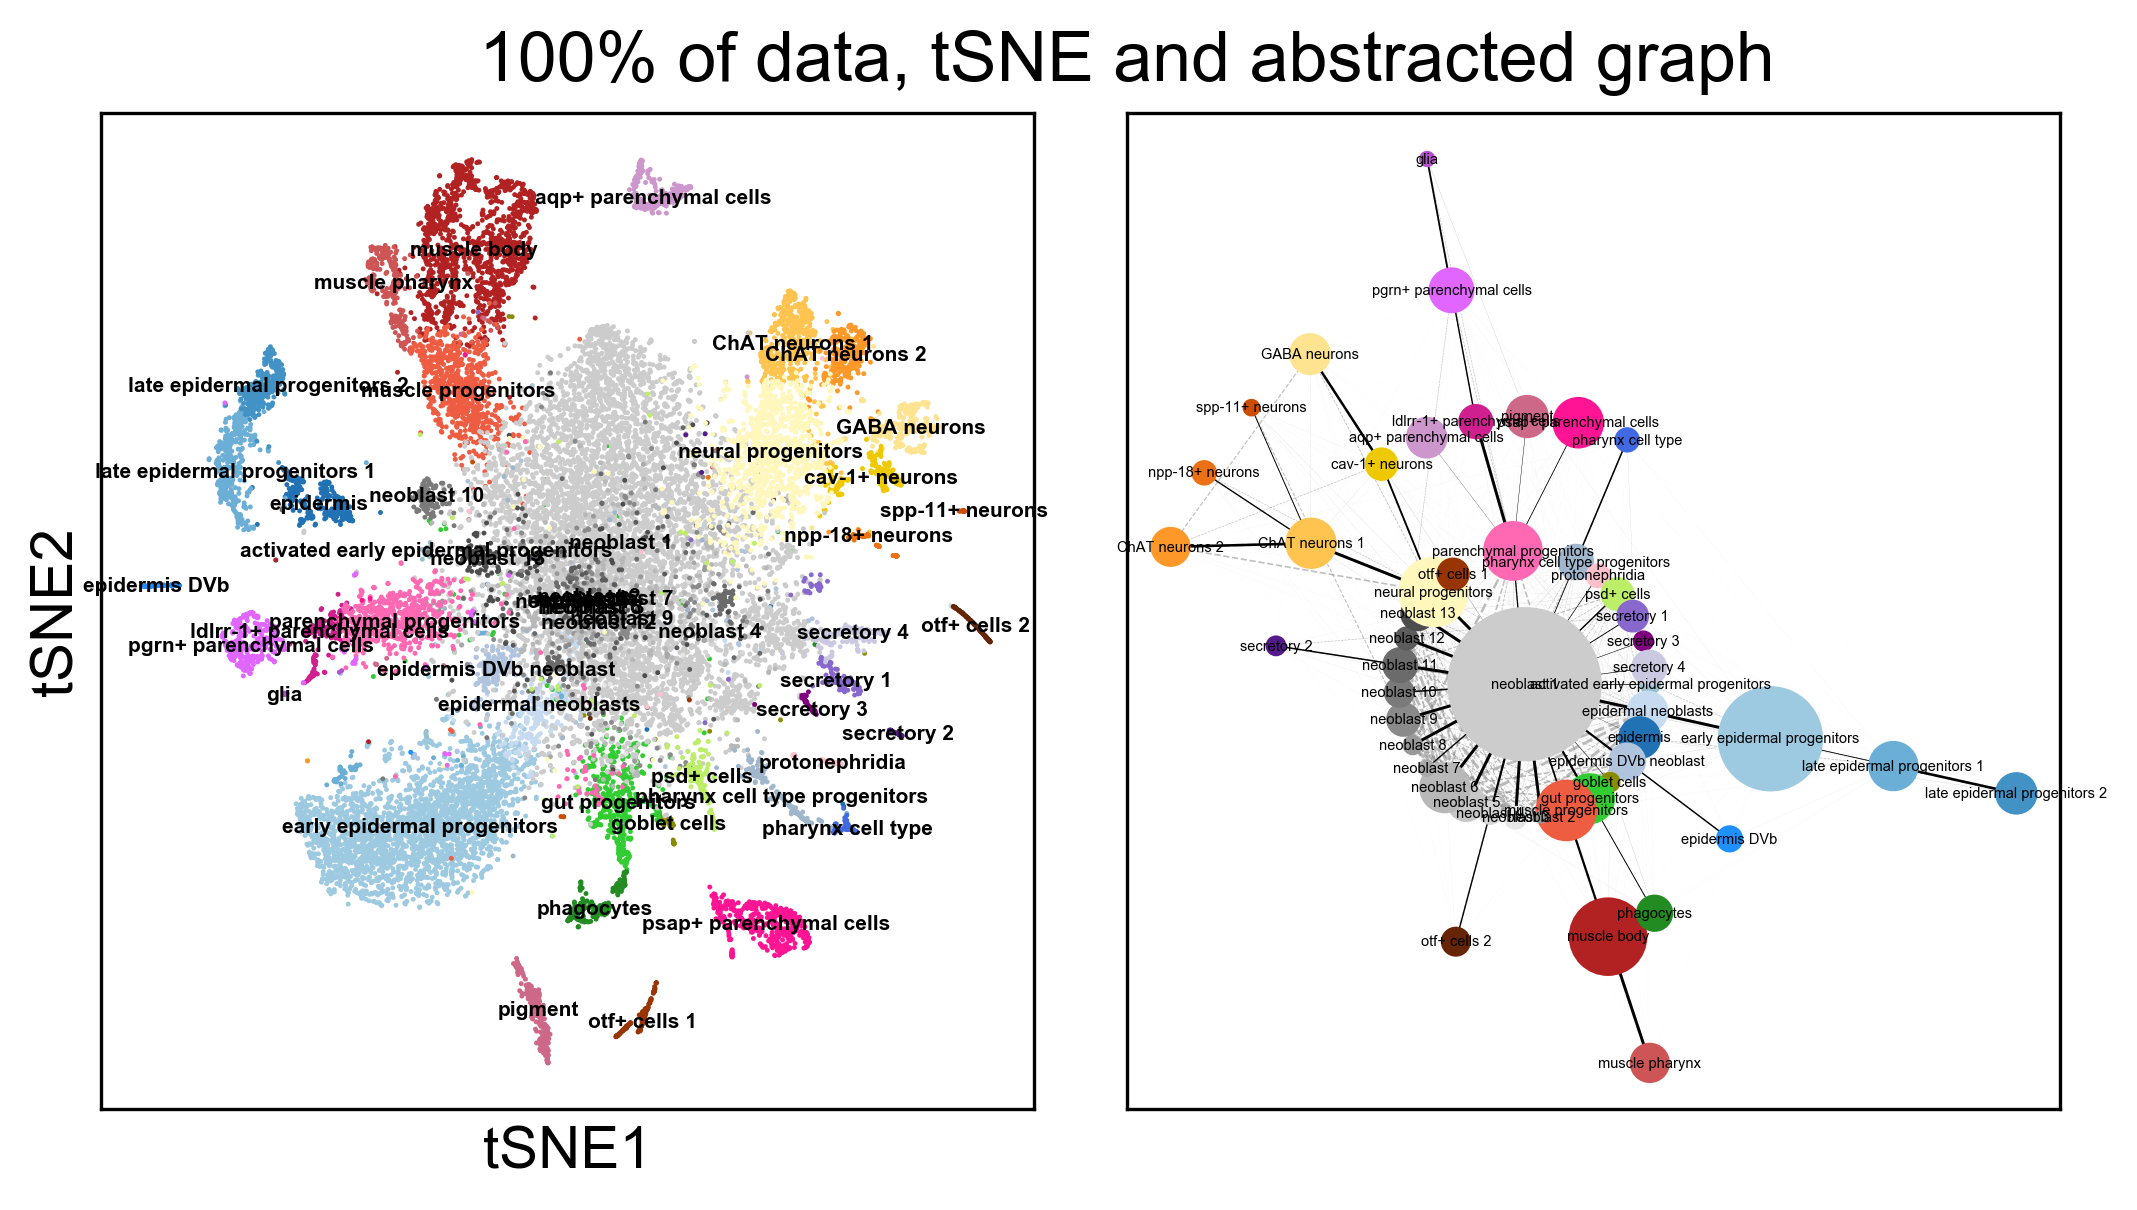

In [10]:
adata = sc.read(results_file)
sc.pl.paga_compare(adata, title='100% of data, tSNE and abstracted graph', solid_edges='confidence_tree', dashed_edges='confidence', **paga_plot_params, save='_100percent')

## Pseudotime

Compute pseudotime: this is diffusion pseudotime of [Haghverdi *et al.* (2016)](https://doi.org/10.1038/nmeth.3971) in the extended implementation of PAGA [Wolf *et al.* (2017)](https://doi.org/10.1101/208819).

In [11]:
adata = sc.read(results_file)
# the following is not necessary for an almost-reproduction of the original pseudotime
# if you want the same results, recompute the graph with connectivities from method='gauss'
# sc.pp.neighbors(adata, method='gauss', n_neighbors=30)  

In [12]:
sc.tl.dpt(adata)

performing Diffusion Pseudotime analysis
    initialized `.distances` `.connectivities` 
    eigenvalues of transition matrix
    [1.         0.9976944  0.9965093  0.99645245 0.99594843 0.99537945
     0.9947217  0.9939476  0.9936672  0.9928949 ]
    finished (0:00:02.33)


In [13]:
adata

AnnData object with n_obs × n_vars = 21612 × 50 
    obs: 'clusters', 'dpt_pseudotime'
    uns: 'clusters_colors', 'clusters_sizes', 'iroot', 'neighbors', 'paga', 'diffmap_evals'
    obsm: 'X_tsne', 'X_diffmap'

In [14]:
adata.write(results_file)

## Exports

Exports for external usage.

In [15]:
!mkdir 'export'

mkdir: export: File exists


In [16]:
adata.obs[['clusters', 'dpt_pseudotime']].to_csv('./export_R_dataset/paga_groups_pseudotime.csv')
np.savetxt('./export_R_dataset/paga_groups_ordered_names.csv',
           adata.obs['clusters'].cat.categories, fmt='%s')
from scipy.io import mmwrite
mmwrite('./export/paga_adjacency_full.mtx', adata.uns['paga']['confidence'])
mmwrite('./export/paga_adjacency_tree.mtx', adata.uns['paga']['confidence_tree'])
entropies = sc.tl.paga_expression_entropies(adata)
np.savetxt('./export/paga_expression_entropies.txt', entropies)
degrees = sc.tl.paga_degrees(adata)
degrees = (degrees - np.min(degrees)) / (np.max(degrees) - np.min(degrees)) 
np.savetxt('./export/paga_degrees.txt', degrees)